# Exam 2023

## Setup

In [1]:
# global
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

In [2]:
#####################
### Problem set 1 ###
#####################
# define input
T = np.array([0., 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10])
R_input = np.array([0., 0.0334, 0.0352, 0.0375, 0.0392, 0.0405, 0.0422, 0.0433, 0.0445, 0.0451, 0.0455, 0.0459, 0.0462])
# sigma, volatility parameter scaling the diffusion term, is known 
sigma = 0.08 

############ 
### 1ai) ###
############

# set initial parameters
param_0 = 0.025, 1.5, 0.07 # no sigma!

# run optimizer
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method= "nelder-mead", args=(sigma,R_input,T), options={'xatol': 1e-20, 'disp': True})
# store results
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x,

# print results
print(f"The fitted parameter values are: r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}")
print(f'SSE of the fit {result.fun:.12f}') # not surprisingly, it depends on xatol!

The fitted parameter values are: r0_hat: 0.032006, a_hat: 1.989699, b_hat: 0.047015
SSE of the fit 0.000000002626


/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_89166/2374405889.py:18: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_cir_no_sigma_obj,param_0,method= "nelder-mead", args=(sigma,R_input,T), options={'xatol': 1e-20, 'disp': True})


In [3]:
############# 
### 1aii) ###
#############
# input estimates in ZCB price and spot rate
R = fid.spot_rate_cir(r0_hat,a_hat,b_hat,sigma,T)
print(R)

[0.         0.0334048  0.03518849 0.0375024  0.03921056 0.04049145
 0.04222307 0.04329243 0.04448048 0.0451005  0.04547535 0.04590434
 0.04622613]


In [4]:
##############################
### 1bi) + 1bii) + 1biii) ###
#############################
np.random.seed(2024) # set a seed
M_simul, T_simul = 10_000, 10 # time steps, maturity
size_ci = 0.99 # confidence interval
r_simul = fid.short_rate_simul(r0_hat,(a_hat,b_hat,sigma),M_simul,T_simul,method = "cir")
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])

# confidence bounds
alpha = (2*a_hat*b_hat)/(sigma**2)
beta = sigma**2/(2*a_hat)

# bounds for r_1
r1 = r_simul[1_000] 
lb_r1, ub_r1 = fid.ci_cir(r0_hat,a_hat,b_hat,sigma,1,size_ci)
print(f'Confidence interval for {r1} with lower bound {lb_r1} and upper bound {ub_r1}')


# confidence bounds
alpha = (2*a_hat*b_hat)/(sigma**2)
beta = sigma**2/(2*a_hat)
lb, ub = fid.ci_cir(r0_hat,a_hat,b_hat,sigma,t_simul,size_ci)
lb_sd, ub_sd = fid.ci_cir(r0_hat,a_hat,b_hat,sigma,100,size_ci)
print(f'Stationary distribution confidence interval with lower bound {lb_sd} and upper bound {ub_sd}')

Confidence interval for 0.05749421005363693 with lower bound 0.02648373002580117 and upper bound 0.06910090147119753
Stationary distribution confidence interval with lower bound 0.027632899472048448 and upper bound 0.07241633929125497


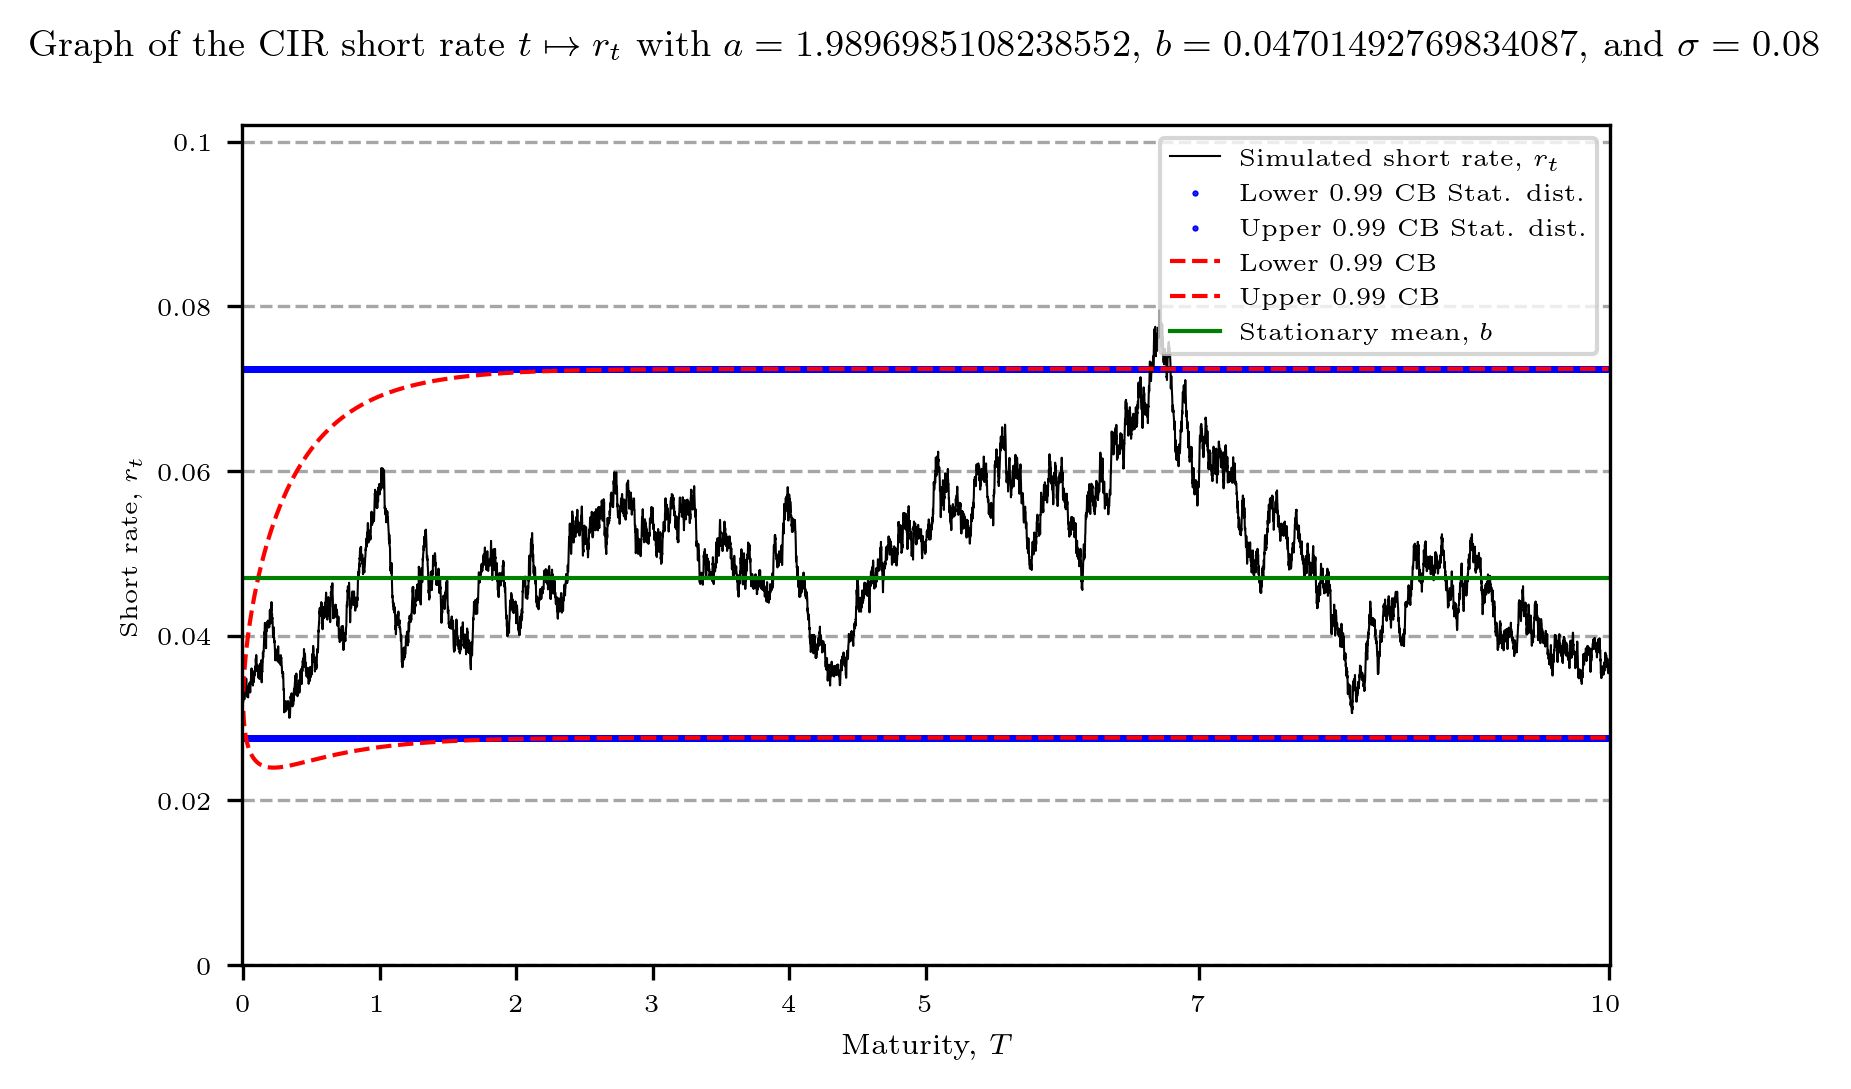

In [5]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Graph of the CIR short rate $t \mapsto r_t$ with $a={a_hat}$, $b={b_hat}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,1,2,3,4,5,7,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity, $T$",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
ax.set_ylabel(f"Short rate, $r_t$",fontsize = 6)

# simulated short rate
ax.plot(t_simul, r_simul, color = 'black', marker = "",linewidth = 0.5, label = "Simulated short rate, $r_t$")

# stationary CI
ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")

# Simulated CI
ax.plot(t_simul, lb,  linewidth = 1,color = 'red', linestyle = "dashed",label=f"Lower {size_ci} CB")
ax.plot(t_simul, ub, linewidth = 1, color = 'red', linestyle = "dashed",label=f"Upper {size_ci} CB")

# stationary mean
ax.plot(t_simul, b_hat*np.ones([M_simul+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")


ax.legend(loc = "upper right",fontsize = 6)
#plt.savefig('CIRsimul.pdf', format='pdf')
plt.show;

In [6]:
############ 
### 1ci) ###
############
np.random.seed(2024) # set a seed
M_simul, N_simul, T_simul = 1_000, 1_000, 2
chi = np.zeros([N_simul])
X = np.zeros([N_simul])
r_simul = np.zeros([M_simul])

for i in range(0,N_simul):
    r_simul = fid.short_rate_simul(r0_hat,(a_hat,b_hat,sigma),M_simul,T_simul,method = "cir")
    # implementing equation 5 in the assignment text
    chi[i] = max(r_simul) # derivative 
    X[i] =np.exp(-sum(r_simul)*(T_simul/M_simul))*max(r_simul) # discounted
    
price = np.mean(X)
#price = sum(X)/N_simul
print(f'Fair price of the Derivative {price:.8f}')

Fair price of the Derivative 0.05428088


In [7]:
#####################
### Problem set 2 ###
#####################
#Input from table:

# Known point
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.02927}]

# Forward Rate Agreements
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03161},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03295},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03418},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03531},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03635},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03731},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.03819},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.03900},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.03975}]

# Knot points on longer maturities
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.03824, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04083, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.04242, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.04346, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.04468, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.04561, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.04633, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.04667, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.04700, "float_freq": "semiannual", "fixed_freq": "semiannual","indices": []}]

data = EURIBOR_fixing + fra_market + swap_market

In [8]:
############
### 2ai) ###
############
T_fit, R_fit = fid.zcb_curve_fit(data,interpolation_options = {"method": "hermite",'degree':3})
curve_indices = [5,11,16,18,20,21,23] # indices
for i in curve_indices:
    print(T_fit[i],R_fit[i])

0.5 0.029057883817419333
1.0 0.033012071599708225
3.0 0.040613828490312295
5.0 0.04329869245998796
10.0 0.04553027606638854
15.0 0.04629571656282437
30.0 0.04704770272466826


In [9]:
#####################
### 2aii) + 2bi) ###
#####################
p_fit = fid.spot_rates_to_zcb(T_fit,R_fit)
f_fit = fid.zcb_to_forward_rates(T_fit,p_fit,horizon=0) # horizon 0 --> instantenous

p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_fit,R_fit,interpolation_options = {"method": "hermite", "degree":3},resolution = 1)

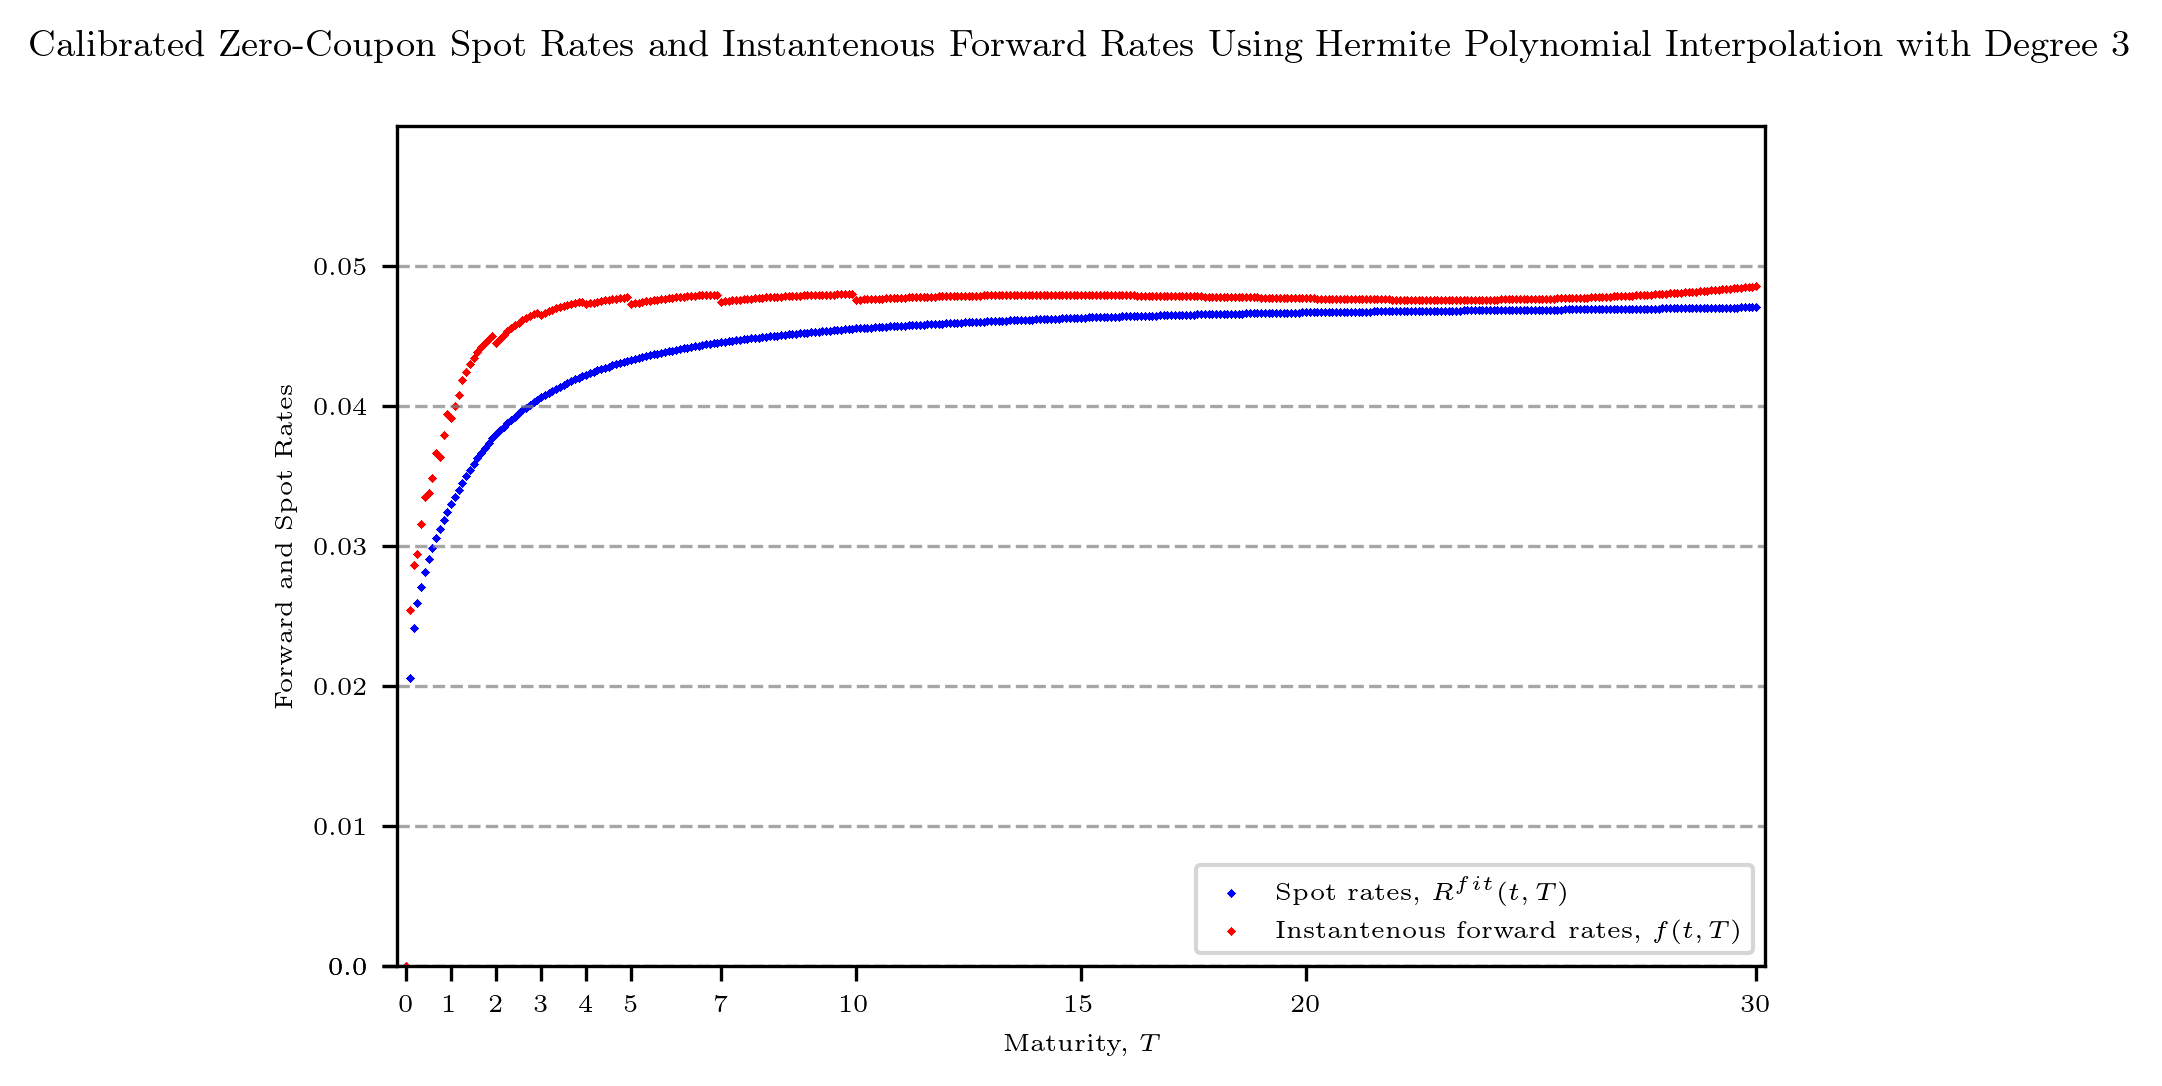

In [10]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Calibrated Zero-Coupon Spot Rates and Instantenous Forward Rates Using Hermite Polynomial Interpolation with Degree 3", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])

xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.0])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.0],fontsize = 6)
ax.set_ylim([0,0.06])
ax.set_ylabel(f"Forward and Spot Rates",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)


p1 = ax.scatter(T_inter, R_inter, s=1, color = 'blue', marker = "x",label="Spot rates, $R^{fit}(t,T)$")
p2 = ax.scatter(T_inter, f_inter, s=1, color = 'red', marker = "x",label="Instantenous forward rates, $f(t,T)$")

plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
#plt.savefig('Curve_fitting.pdf', format='pdf')
plt.show();

In [11]:
############
### 2ci) ###
############
# DV01 when bumping the entire spot rate curve
idx_swap, size_bump = 14, 0.0001
R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_inter,size_bump,T_inter,R_inter,p_inter)
S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping entire spot rate curve is {10_000*DV01} bps")
print(f'Sanity check: {S_swap_bump}')

DV01 for the swap with maturity: 7 when bumping entire spot rate curve is 5.97555908496367 bps
Sanity check: 5.995191911434162


In [12]:
#############
### 2cii) ###
#############
# DV01 when bumping a single point
for T_bump in [1,2,3,5,7]:
    idx_swap, T_bump, size_bump = 14, T_bump, 0.0001
    R_inter_bump, p_inter_bump = fid.spot_rate_bump(T_bump,size_bump,T_inter,R_inter,p_inter)
    S_swap_bump = fid.zcb_to_accrual_factor(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
    R_swap_bump = fid.zcb_to_par_swap_rate(0,data[idx_swap]["maturity"],"semiannual",T_inter,p_inter_bump)
    DV01 = (R_swap_bump-data[idx_swap]["rate"])*S_swap_bump
    print(f"DV01 for the swap with maturity: {data[idx_swap]['maturity']} when bumping spot rate at T: {T_bump} by {10000*size_bump} bps is {10000*DV01} bps")

DV01 for the swap with maturity: 7 when bumping spot rate at T: 1 by 1.0 bps is -0.07976688493191218 bps
DV01 for the swap with maturity: 7 when bumping spot rate at T: 2 by 1.0 bps is -0.05997429684478763 bps
DV01 for the swap with maturity: 7 when bumping spot rate at T: 3 by 1.0 bps is -0.042057205752221716 bps
DV01 for the swap with maturity: 7 when bumping spot rate at T: 5 by 1.0 bps is -0.01144660779282074 bps
DV01 for the swap with maturity: 7 when bumping spot rate at T: 7 by 1.0 bps is 5.1356110630379925 bps


In [13]:
#####################
### Problem set 3 ###
#####################
# compute array of time to maturities for T={0.0,0.5,...,10}
T_max = 4
alpha = 0.5
M = int(T_max/alpha)+1
T = np.array([i*alpha for i in range(M)])

R = np.array([0.0,0.0385, 0.0431, 0.0463, 0.0486, 0.0502, 0.0513, 0.0521, 0.0527]) 

strike = 0.05 # R, K
sigma_market = np.array([np.nan,np.nan,0.223,0.241,0.260,0.283,0.312,0.355,0.402])

In [14]:
###########
### 3a) ###
###########
p = fid.spot_rates_to_zcb(T,R)
f6M_libor_rates = fid.zcb_to_forward_LIBOR_rates(T,p,horizon=1)
print(' '.join(f'{rate:.5f}' for rate in f6M_libor_rates[1:-1]))

0.03887 0.04827 0.05340 0.05628 0.05741 0.05761 0.05772


In [15]:
###################
### 3bi+ii+iii) ###
###################
# IRS
par_swap_rate = fid.zcb_to_par_swap_rate(T[0],T[8],'semiannual',T,p)
print(f'The par swap rate is {par_swap_rate:.6f}')

# IR CAP
idx_n, idx_N = 2, 8 # no caplet for index 0,1 since we already know and thus no uncertainty

price_caplet = np.zeros([M])
alpha = np.zeros([M])
L = np.zeros([M])

for i in range(1,M):
    alpha[i] = T[i]-T[i-1] # will be semiannual
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]
    if i > 1:
        price_caplet[i] = fid.black_caplet_price(sigma_market[i],T[i],strike,alpha[i],p[i],L[i],type='call') 
    
price_cap = np.sum(price_caplet)
S_swap = fid.zcb_to_accrual_factor(T[0],T[idx_N],'semiannual',T,p)
#distributed price of caps into payments as a spread on top of floating rate in order to be insured against floating rate of >5 % (strike)
premium = (price_cap/S_swap) 
print(f"Price of cap: {price_cap:.6f} and Cap spread (premium): {int(premium*10_000)} bps.")

# IR Swaption
sigma = 0.39
S_swaption = fid.zcb_to_accrual_factor(T[4],T[8],"semiannual",T,p)
swaption = fid.black_swaption_price(sigma,T[4],strike,S_swaption,R[4],type = "call")
print(f"Price of Swaption: {swaption*10_000} bps")

The par swap rate is 0.053078
Price of cap: 0.036122 and Cap spread (premium): 100 bps.
Price of Swaption: 169.56547914553317 bps


accrual factor: 3.297971, 2Y4Y par swap rate: 0.053116
The market implied volatilities are [0.31555267 0.27571732 0.2417579  0.21251243 0.18717002 0.16594365
 0.15032339 0.1418881  0.14075951 0.14458939 0.15091799 0.15822536
 0.16563506]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 450
         Function evaluations: 745
Parameters from fit: [ 0.05923559  0.69568014  0.59958157 -0.34874584], squared dev: 1.5631455864269193e-08
Parameters from the fit: sigma_0: 0.059235594284689864, beta: 0.6956801388295497, upsilon: 0.599581573464507, rho: -0.34874584230345473
Implied volatilities from market prices:
[0.31554091 0.27570082 0.24183229 0.21249729 0.18711959 0.16596473
 0.15030724 0.14189341 0.14077659 0.14461359 0.15090519 0.15816565
 0.16567474]


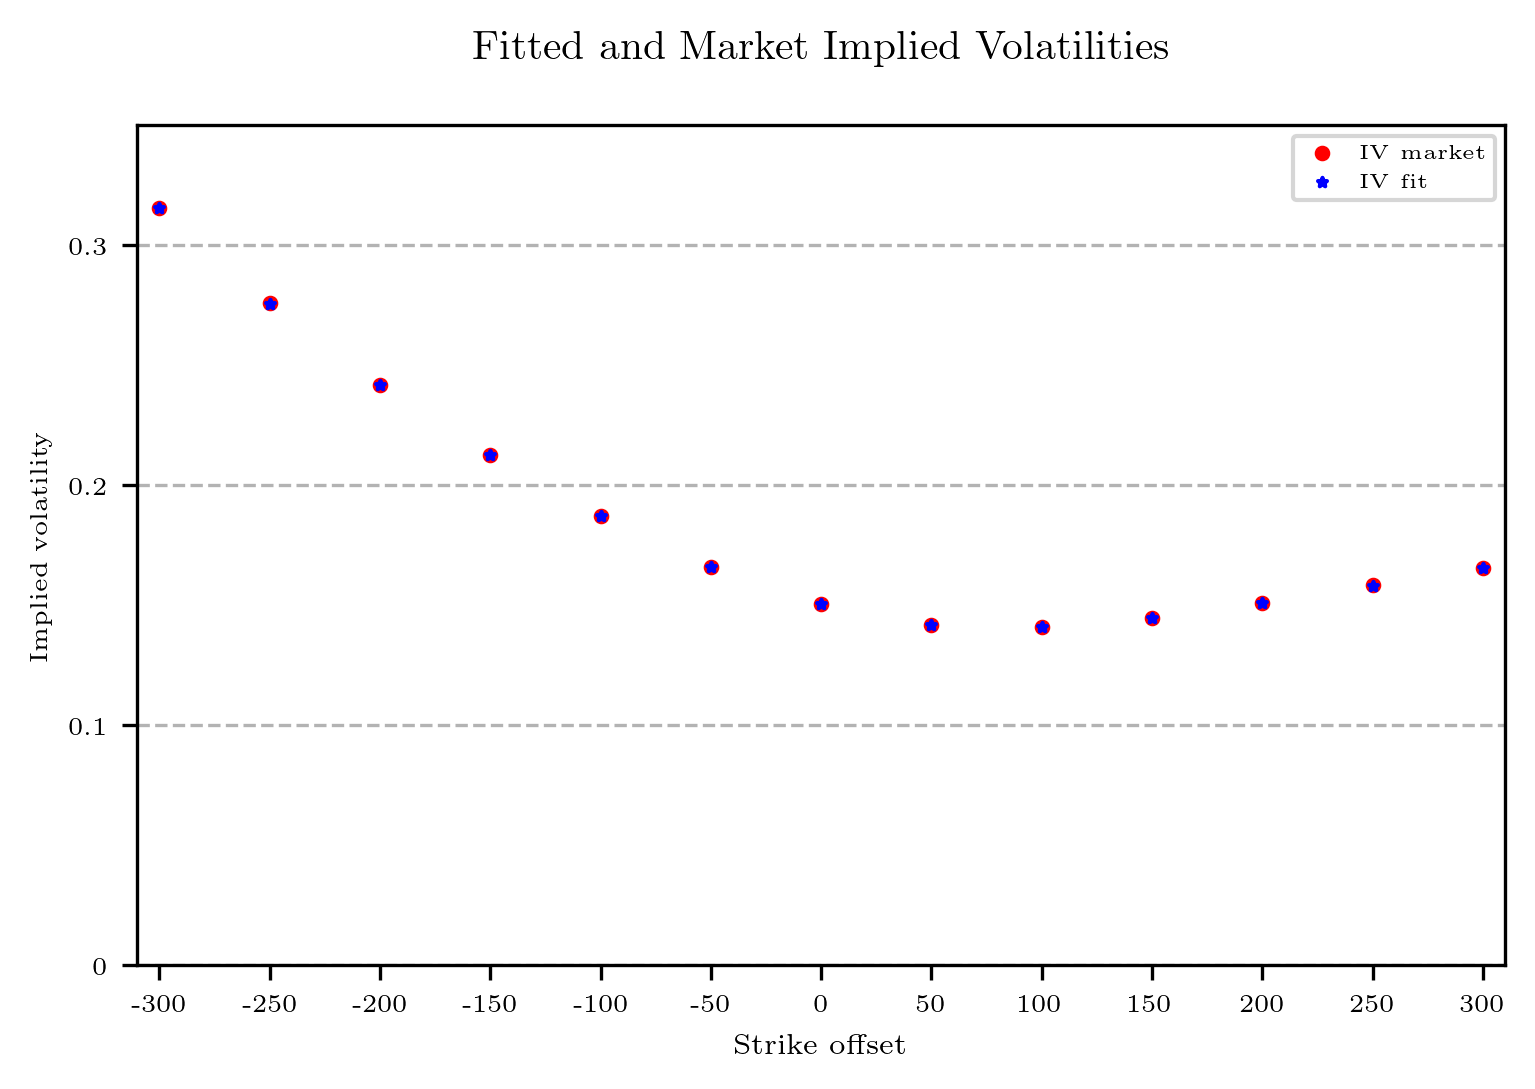

price after bumping upsilon: 0.03796525384832291, diff: -1.1692615167709086
price after bumping rho: 0.03788178565774934, diff: -2.0039434225065795
price after bumping spot rates: 0.03779820830021552, diff: -2.8397169978448127 in percent :-0.007456813128462743


In [16]:
#####################
### Problem set 4 ###
#####################

############
### 4ai) ###
############
alpha = 0.5
T_max = 6
idx_exer, idx_mat = 4, 12 # 2Y4Y Forward Swap rate T_n = 2, T_N=6
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
N_swaption = len(K_swaption_offset)
M = int(round(T_max/alpha)+1)
T = np.array([i*alpha for i in range(0,M)])
p = np.array([1,0.98322948, 0.96455878, 0.94449414, 0.92344747, 0.90175113, 0.87967118,0.85741902, 0.83516131, 0.81302835, 0.79112104, 0.76951663, 0.7482734])
price_market = np.array([0.0995524, 0.08350629, 0.06774531, 0.05248227, 0.03808218, 0.02519355, 0.01482874, 0.00785645, 0.00404525, 0.00219232, 0.00128815, 0.00081635, 0.00054773])

# compute accrual factor
S_swap = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_swap += alpha*p[i]

# report forward par swap rate    
R_swap = (p[idx_exer] - p[idx_mat])/S_swap
print(f"accrual factor: {S_swap:.6f}, 2Y4Y par swap rate: {R_swap:.6f}")

#############
### 4aii) ###
#############
# Compute Black Implied Volatilities for All Strikes
K, iv_market = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_market[i],T[idx_exer],K[i],S_swap,R_swap,type = "call", iv0 = 0.25, max_iter = 1000, prec = 1.0e-12)
print(f'The market implied volatilities are {iv_market}')

#############
### 4bi) ###
#############
# initial guess per assignment text
param_0 = 0.04, 0.5, 0.4,- 0.3 

# run optimizer
result = minimize(fid.fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv_market,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': True})
print(f"Parameters from fit: {result.x}, squared dev: {result.fun}")
sigma_0, beta, upsilon, rho = result.x

iv_fit, price_fit = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T[idx_exer],K[i],S_swap,R_swap,type = "call")
print(f"Parameters from the fit: sigma_0: {sigma_0}, beta: {beta}, upsilon: {upsilon}, rho: {rho}")
print(f"Implied volatilities from market prices:")
print(iv_fit)

#####################
### 4aii) + 4bii) ###
#####################
# plot
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))
fig.suptitle(f"Fitted and Market Implied Volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.35])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied volatility",fontsize = 6)
p1 = ax.scatter(K_swaption_offset, iv_market, s = 30, color = 'red', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 5, color = 'blue', marker = "*",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
#plt.savefig('Black_IV.pdf', format='pdf')
plt.show();

#############
### 4ci) ###
#############
# identify position
idx_position = 4 # position of K_offset = -100

# Bumping sigma_0
upsilon_bump = upsilon - 0.02

# recompute implied volatility 
iv_upsilon_0 = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0,beta,upsilon_bump,rho,type = "call")
# use Black's formula to value payer swaption
price_upsilon_0 = fid.black_swaption_price(iv_upsilon_0,T[idx_exer],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping upsilon: {price_upsilon_0}, diff: {(price_upsilon_0-price_market[idx_position])*10_000}")

##############
### 4cii) ###
##############
# identify position
idx_position = 4 # position of K_offset = -100

# Bumping sigma_0
rho_bump = rho + 0.1

# recompute implied volatility 
iv_rho_bump = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho_bump,type = "call")
# use Black's formula to value payer swaption
price_rho_bump = fid.black_swaption_price(iv_rho_bump,T[idx_exer],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping rho: {price_rho_bump}, diff: {(price_rho_bump-price_market[idx_position])*10_000}")

###############
### 4ciii) ###
###############
# identify position
idx_position = 4 # position of K_offset = -100

# Bumping the entire spot rate curve
R = fid.zcb_to_spot_rates(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.spot_rates_to_zcb(T,R_bump)
S_bump = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_bump += alpha*p_bump[i]
R_swap_bump = (p_bump[idx_exer] - p_bump[idx_mat])/S_bump
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap_bump,sigma_0,beta,upsilon,rho,type = "call")
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exer],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {(price_delta-price_market[idx_position])*10_000} in percent :{(price_delta-price_market[idx_position])/price_market[idx_position]}")